In [38]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()
image_path = "german_shepard_dog.jpeg"
# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using cache found in /Users/arunesh/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/arunesh/PycharmProjects/Breaking-reCAPTCHAv2/pyenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/arunesh/PycharmProjects/Breaking-reCAPTCHAv2/pyenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

def print_output_image(input_tensor, probabilities):
    visualize_image(input_tensor)
    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
        
def predict_output_inception_image_path(image_path):
    input_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
      output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print_output_image(input_tensor, probabilities)

def predict_output_inception_image(input_image):
    # Check if input is a PIL image or a tensor
    if isinstance(input_image, torch.Tensor):
        # If tensor, ensure it has shape [3, H, W] and add batch dimension
        input_tensor = input_image
        if input_tensor.dim() == 3:
            input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
        elif input_tensor.dim() == 4:
            input_batch = input_tensor  # Already has batch dimension
        else:
            raise ValueError("Tensor input_image must have 3 or 4 dimensions (C, H, W) or (B, C, H, W)")
    else:
        # If it's a PIL Image, apply the preprocessing
        preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            # Uncomment if input images are not normalized
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
      output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print_output_image(input_tensor, probabilities)


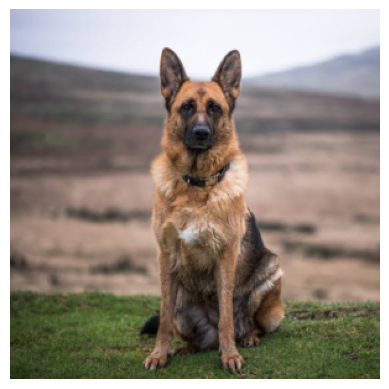

German shepherd 0.4096639156341553
dhole 0.023088591173291206
malinois 0.021833674982190132
kelpie 0.021249942481517792
African hunting dog 0.016897380352020264


In [40]:
predict_output_inception_image_path(image_path)

Step 0, Loss: -1.7722822320820342e-08, Predicted label: malinois
Step 50, Loss: -6.954446973850281e-08, Predicted label: malinois
Step 100, Loss: -1.2782602709648927e-07, Predicted label: German shepherd
Step 150, Loss: -2.376377352675263e-07, Predicted label: German shepherd
Step 200, Loss: -5.293971128139674e-08, Predicted label: malinois
Step 250, Loss: -0.00014590560749638826, Predicted label: sombrero
Step 300, Loss: -0.07517270743846893, Predicted label: lacewing
Step 350, Loss: -0.6904222965240479, Predicted label: spoonbill
Step 400, Loss: -0.8783044815063477, Predicted label: spoonbill
Step 450, Loss: -0.911833643913269, Predicted label: spoonbill


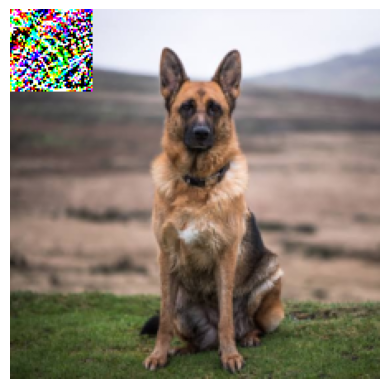

In [44]:
# Adversarial patch training loop
categories = []
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch directly without altering the base image
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at the top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(output, dim=1)
        
        # Calculate loss to maximize the target class probability
        loss = -probabilities[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(probabilities, 1)
            predicted_label = categories[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch

# Define the target class and train the patch on an example image
target_class = 129  # Replace with your desired target class index (Spoonbill)
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image 235
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct_inception.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)

patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

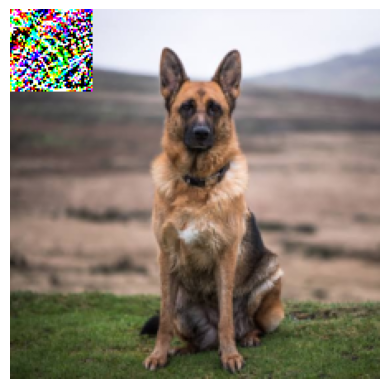

spoonbill 0.9233830571174622
green mamba 0.0055599031038582325
sombrero 0.005533406976610422
bathing cap 0.002810258185490966
lacewing 0.002264198614284396


In [48]:
predict_output_inception_image(patched_image)